In [1]:
!pip install mlflow

In [2]:
import mlflow

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from transformers import AutoTokenizer, AutoModel
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt  # Import matplotlib

In [4]:
# 1. Embed ข้อความด้วย WangchanBERTa
def get_wangchanberta_embeddings(texts, model_name='airesearch/wangchanberta-base-att-spm-uncased', max_length=128):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=max_length)
    with torch.no_grad():
        model_output = model(**encoded_inputs)
    embeddings = model_output.last_hidden_state.mean(dim=1)
    return embeddings.numpy()

In [5]:
# 2. เตรียมข้อมูลสำหรับ Deep Learning
class SentimentDataset(Dataset):
    def __init__(self, embeddings, scores):
        # Convert to tensors at initialization
        self.embeddings = torch.tensor(embeddings, dtype=torch.float)
        self.scores = torch.tensor(scores, dtype=torch.float)
        # Verify shapes
        assert self.embeddings.shape[0] == self.scores.shape[0], "Mismatch in number of samples"
        assert self.scores.shape[1] == 3, f"Expected scores to have shape [n_samples, 3], got {self.scores.shape}"

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.scores[idx]  # Already tensors

In [6]:
# 3. สร้างโมเดล Deep Learning
# def create_model(input_size, hidden_size=256, num_layers=3):
#     model = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
#     output_size = hidden_size * 2  # Bidirectional
#     return nn.Sequential(
#         model,
#         nn.Linear(output_size, 3)
#     )

In [7]:
# 3. สร้างโมเดล Deep Learning โดยปรับ dropout rate เพื่อลดขนาด layer
def create_model(input_size, hidden_size, num_layers, dropout_rate=0.5):
    class LSTMWithDropout(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
            super(LSTMWithDropout, self).__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.dropout = nn.Dropout(dropout_rate)
            self.linear = nn.Linear(hidden_size, 3)

        def forward(self, x):
            if x.dim() == 2:  # [batch_size, input_size] -> [batch_size, 1, input_size]
                x = x.unsqueeze(1)
            output, (hidden, cell) = self.lstm(x)
            output = output[:, -1, :]  # Take last time step
            output = self.dropout(output)
            output = self.linear(output)
            return output, (hidden, cell)  # Returns tuple

    return LSTMWithDropout(input_size, hidden_size, num_layers, dropout_rate)

In [8]:
def train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    epochs=10,
    eval_interval=1,
):
    model.train()
    epoch_losses = []
    eval_losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for embeddings, scores in train_loader:
            optimizer.zero_grad()
            # แก้ไขตรงนี้
            output, _ = model(embeddings)  # เรียกใช้ model โดยตรง
            # output = output[:, -1, :] if output.ndim > 2 else output  # อาจไม่จำเป็น
            # batch_size = output.shape[0]  # อาจไม่จำเป็น
            # output = output.contiguous().view(batch_size, -1)  # ไม่จำเป็น
            # output = model[1](output)  # ลบออก
            loss = criterion(output, scores)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_epoch_loss = epoch_loss / len(train_loader)
        epoch_losses.append(avg_epoch_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_epoch_loss:.4f}")

        if (epoch + 1) % eval_interval == 0:
            model.eval()
            eval_loss = 0
            with torch.no_grad():
                for eval_embeddings, eval_scores in test_loader:
                    # แก้ไขตรงนี้
                    eval_output, _ = model(eval_embeddings)  # เรียกใช้ model โดยตรง
                    # eval_output = (
                    #     eval_output[:, -1, :] if eval_output.ndim > 2 else eval_output
                    # )  # อาจไม่จำเป็น
                    # eval_batch_size = eval_output.shape[0]  # อาจไม่จำเป็น
                    # eval_output = eval_output.contiguous().view(eval_batch_size, -1)  # ไม่จำเป็น
                    # eval_output = model[1](eval_output)  # ลบออก
                    eval_loss_batch = criterion(eval_output, eval_scores)
                    eval_loss += eval_loss_batch.item()
            avg_eval_loss = eval_loss / len(test_loader)
            eval_losses.append(avg_eval_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Eval Loss: {avg_eval_loss:.4f}")
            model.train()
    return epoch_losses, eval_losses

In [9]:
# 4. Normalize Scores ด้วย StandardScaler
def normalize_scores(scores):
    scaler = StandardScaler()
    return scaler.fit_transform(scores), scaler


In [10]:
# 5. ประเมินโมเดล
def evaluate_model(model, test_loader, criterion, scaler):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for embeddings, scores in test_loader:
            # แก้ไขตรงนี้
            output, _ = model(embeddings)  # เรียกใช้ model โดยตรง
            # output = output[:, -1, :] if output.ndim > 2 else output
            # batch_size = output.shape[0]
            # output = output.contiguous().view(batch_size, -1)
            # output = model[1](output)

            loss = criterion(output, scores)
            total_loss += loss.item()

            # Assuming output and scores are tensors, move them to CPU before converting to numpy
            preds = output.cpu().numpy()
            labels = scores.cpu().numpy()

            # Inverse transform the predictions and labels if necessary
            if scaler:
                preds = scaler.inverse_transform(preds)
                labels = scaler.inverse_transform(labels)

            all_preds.extend(preds)
            all_labels.extend(labels)

    # Calculate metrics after the loop
    mse = mean_squared_error(all_labels, all_preds)
    mae = mean_absolute_error(all_labels, all_preds)
    r2 = r2_score(all_labels, all_preds)
    avg_loss = total_loss / len(test_loader)

    return mse, mae, r2, avg_loss

In [11]:
# 6. สร้างและ Train โมเดลต่าง ๆ


# def train_and_evaluate(df, epochs=20, batch_size=32, hidden_size=256, num_layers=3, eval_interval=1):
#     embeddings = get_wangchanberta_embeddings(df['complain_detail'].tolist())
#     scores = df[['positive', 'neutral', 'negative']].values
#     normalized_scores, scaler = normalize_scores(scores)
#     X_train, X_test, y_train, y_test = train_test_split(
#         embeddings, normalized_scores, test_size=0.3, random_state=42
#     )
#     train_dataset = SentimentDataset(X_train, y_train)
#     test_dataset = SentimentDataset(X_test, y_test)
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size)
#     input_size = embeddings.shape[1]
#     model = create_model(input_size, hidden_size, num_layers)
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
#     epoch_losses, eval_losses = train_model(
#         model, train_loader, test_loader, criterion, optimizer, epochs, eval_interval
#     )  # Get epoch losses
#     mse, mae, r2, _ = evaluate_model(
#         model, test_loader, criterion, scaler
#     )  # Get final evaluation metrics
#     # Plotting the loss curve
#     plt.plot(epoch_losses, label="Train Loss")  # Plot training loss
#     eval_epochs = range(eval_interval, epochs + 1, eval_interval) # Create x-axis values for eval_losses
#     plt.plot(eval_epochs, eval_losses, label="Evaluation Loss")
#     plt.title("Training and Evaluation Loss")
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.legend()  # Add legend to differentiate the plots
#     plt.show()
#     return mse, mae, r2, model, scaler

In [12]:
# learning_rates = [
#  0.0004,0.00045,0.0005,0.00055,0.0006
# ]
# def train_and_evaluate(
#     df,
#     epochs=20,
#     batch_size=32,
#     hidden_size=256,
#     num_layers=3,
#     eval_interval=5,
#     weight_decay=5e-06,  # Fix weight_decay to the best value found
#     learning_rates=learning_rates,  # Learning rates to try
# ):
#     embeddings = get_wangchanberta_embeddings(df["complain_detail"].tolist())
#     scores = df[["positive", "neutral", "negative"]].values
#     normalized_scores, scaler = normalize_scores(scores)
#     X_train, X_test, y_train, y_test = train_test_split(
#         embeddings, normalized_scores, test_size=0.2, random_state=42
#     )
#     train_dataset = SentimentDataset(X_train, y_train)
#     test_dataset = SentimentDataset(X_test, y_test)
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size)
#     input_size = embeddings.shape[1]

#     best_eval_loss = float("inf")
#     best_model = None
#     best_learning_rate = None

#     for learning_rate in learning_rates:  # Loop through learning rates
#         print(f"\nTraining with learning_rate = {learning_rate}")
#         model = create_model(input_size, hidden_size, num_layers)
#         criterion = nn.MSELoss()
#         optimizer = optim.Adam(
#             model.parameters(), lr=learning_rate, weight_decay=weight_decay
#         )  # Create optimizer with current learning_rate

#         epoch_losses, eval_losses = train_model(
#             model,
#             train_loader,
#             test_loader,
#             criterion,
#             optimizer,
#             epochs,
#             eval_interval,
#         )  # Train the model

#         # Evaluate the final model
#         mse, mae, r2, _ = evaluate_model(model, test_loader, criterion, scaler)

#         # Print results for this learning_rate
#         print(
#             f"learning_rate: {learning_rate}, MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}"
#         )

#         # เก็บค่า Evaluation Loss สุดท้าย (หรือเฉลี่ย) เพื่อเปรียบเทียบ
#         avg_final_eval_loss = (
#             eval_losses[-1] if eval_losses else float("inf")
#         )  # Get the last eval loss

#         # Check if this model is the best
#         if avg_final_eval_loss < best_eval_loss:
#             best_eval_loss = avg_final_eval_loss
#             best_model = model
#             best_learning_rate = learning_rate

#         # Plotting the loss curve for each learning_rate
#         plt.plot(epoch_losses, label=f"Train Loss (lr={learning_rate})")
#         eval_epochs = range(eval_interval, epochs + 1, eval_interval)
#         plt.plot(eval_epochs, eval_losses, label=f"Eval Loss (lr={learning_rate})")
#         plt.title(f"Training and Evaluation Loss (learning_rate={learning_rate})")
#         plt.xlabel("Epoch")
#         plt.ylabel("Loss")
#         plt.legend()
#         plt.show()

#     # Print the best results
#     print("\nBest Model Results:")
#     print(f"Best learning_rate: {best_learning_rate}")
#     mse, mae, r2, _ = evaluate_model(best_model, test_loader, criterion, scaler)
#     print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")

#     return mse, mae, r2, best_model, scaler

In [13]:
# def train_and_evaluate(
#     df,
#     epochs=20,
#     batch_size=32,
#     hidden_size=256,
#     num_layers=3,
#     eval_interval=5,
#     weight_decay=5e-06,
#     learning_rate=0.00055,  # Fix learning_rate to the best value found
#     dropout_rates=[0, 0.1, 0.2],  # Dropout rates to try
# ):
#     embeddings = get_wangchanberta_embeddings(df["complain_detail"].tolist())
#     scores = df[["positive", "neutral", "negative"]].values
#     normalized_scores, scaler = normalize_scores(scores)
#     X_train, X_test, y_train, y_test = train_test_split(
#         embeddings, normalized_scores, test_size=0.2, random_state=42
#     )
#     train_dataset = SentimentDataset(X_train, y_train)
#     test_dataset = SentimentDataset(X_test, y_test)
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size)
#     input_size = embeddings.shape[1]

#     best_eval_loss = float("inf")
#     best_model = None
#     best_dropout_rate = None

#     for dropout_rate in dropout_rates:  # Loop through dropout rates
#         print(f"\nTraining with dropout_rate = {dropout_rate}")
#         model = create_model(
#             input_size, hidden_size, num_layers, dropout_rate
#         )  # Create model with current dropout_rate
#         criterion = nn.MSELoss()
#         optimizer = optim.Adam(
#             model.parameters(), lr=learning_rate, weight_decay=weight_decay
#         )  # Create optimizer with fixed learning_rate and weight_decay

#         epoch_losses, eval_losses = train_model(
#             model, train_loader, test_loader, criterion, optimizer, epochs, eval_interval
#         )  # Train the model

#         # Evaluate the final model
#         mse, mae, r2, _ = evaluate_model(model, test_loader, criterion, scaler)

#         # Print results for this dropout_rate
#         print(
#             f"dropout_rate: {dropout_rate}, MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}"
#         )

#         # เก็บค่า Evaluation Loss สุดท้าย (หรือเฉลี่ย) เพื่อเปรียบเทียบ
#         avg_final_eval_loss = (
#             eval_losses[-1] if eval_losses else float("inf")
#         )  # Get the last eval loss

#         # Check if this model is the best
#         if avg_final_eval_loss < best_eval_loss:
#             best_eval_loss = avg_final_eval_loss
#             best_model = model
#             best_dropout_rate = dropout_rate

#         # Plotting the loss curve for each dropout_rate
#         plt.plot(epoch_losses, label=f"Train Loss (dr={dropout_rate})")
#         eval_epochs = range(eval_interval, epochs + 1, eval_interval)
#         plt.plot(eval_epochs, eval_losses, label=f"Eval Loss (dr={dropout_rate})")
#         plt.title(f"Training and Evaluation Loss (dropout_rate={dropout_rate})")
#         plt.xlabel("Epoch")
#         plt.ylabel("Loss")
#         plt.legend()
#         plt.show()

#     # Print the best results
#     print("\nBest Model Results:")
#     print(f"Best dropout_rate: {best_dropout_rate}")
#     mse, mae, r2, _ = evaluate_model(best_model, test_loader, criterion, scaler)
#     print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")

#     return mse, mae, r2, best_model, scaler

In [14]:
def train_and_evaluate(
    df,
    epochs=20,
    batch_size=32,
    hidden_size=256,
    num_layers=3,
    eval_interval=5,
    learning_rates=[0.0001, 0.00025, 0.0005, 0.00075],
    dropout_rates=[0.15, 0.2, 0.25],
    weight_decays=[4.5e-06, 5e-06],
    patience=10
):
    embeddings = get_wangchanberta_embeddings(df["complain_detail"].tolist())
    scores = df[["positive", "neutral", "negative"]].values
    normalized_scores, scaler = normalize_scores(scores)
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, normalized_scores, test_size=0.3, random_state=42
    )
    train_dataset = SentimentDataset(X_train, y_train)
    test_dataset = SentimentDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    input_size = embeddings.shape[1]

    best_eval_loss = float("inf")
    best_model = None
    best_params = {}

    for learning_rate in learning_rates:
        for dropout_rate in dropout_rates:
            for weight_decay in weight_decays:
                print(f"\nTraining with lr={learning_rate}, dr={dropout_rate}, wd={weight_decay}")
                model = create_model(input_size, hidden_size, num_layers, dropout_rate)
                criterion = nn.MSELoss()
                optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
                scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.7, verbose=False)

                epoch_losses, eval_losses = [], []
                no_improve_epochs = 0

                for epoch in range(epochs):
                    epoch_loss = train_model_epoch(model, train_loader, criterion, optimizer)
                    epoch_losses.append(epoch_loss)

                    if (epoch + 1) % eval_interval == 0:
                        eval_loss = evaluate_model_loss(model, test_loader, criterion)
                        eval_losses.append(eval_loss)
                        scheduler.step(eval_loss)
                        print(f"Epoch {epoch + 1}, Train Loss: {epoch_loss:.4f}, Eval Loss: {eval_loss:.4f}")

                        if eval_loss < best_eval_loss:
                            best_eval_loss = eval_loss
                            best_model = model.state_dict()
                            best_params = {"learning_rate": learning_rate, "dropout_rate": dropout_rate, "weight_decay": weight_decay}
                            no_improve_epochs = 0
                        else:
                            no_improve_epochs += 1
                            if no_improve_epochs >= patience:
                                print(f"Early stopping after {patience} epochs without improvement.")
                                break

                if best_model is not None:
                    model.load_state_dict(best_model)
                    mse, mae, r2, _ = evaluate_model(model, test_loader, criterion, scaler)
                    print(f"lr: {learning_rate:.6f}, dr: {dropout_rate:.3f}, wd: {weight_decay:.6e}, MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

                    plt.plot(epoch_losses, label="Train Loss")
                    eval_epochs = range(eval_interval, len(epoch_losses) + 1, eval_interval)
                    plt.plot(eval_epochs, eval_losses, label="Eval Loss")
                    plt.title(f"Training Loss (lr={learning_rate:.6f}, dr={dropout_rate:.3f}, wd={weight_decay:.6e})")
                    plt.xlabel("Epoch")
                    plt.ylabel("Loss")
                    plt.legend()
                    plt.show()

    print("\nBest Model Results:")
    print(f"Best lr: {best_params['learning_rate']:.6f}, Best dr: {best_params['dropout_rate']:.3f}, Best wd: {best_params['weight_decay']:.6e}")
    if best_model is not None:
        model.load_state_dict(best_model)
        mse, mae, r2, _ = evaluate_model(model, test_loader, criterion, scaler)
        print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")
        return mse, mae, r2, model, scaler, best_params
    else:
        print("No model was trained successfully.")
        return None, None, None, None, None, 

def train_model_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs, _ = model(inputs)  # Unpack tuple to get only the output tensor
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_model_loss (model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs, _ = model(inputs)  # Unpack tuple to get only the output tensor
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(test_loader)

In [15]:
# def train_and_evaluate(
#     df,
#     epochs=20,
#     batch_size=32,
#     hidden_size=256,
#     num_layers=3,
#     eval_interval=5,
#     # learning_rates=[0.00054, 0.00055, 0.00056],  # Learning rates to try
#     learning_rates=[0.0001, 0.00025, 0.0005, 0.00075],  # Learning rates to try
#     dropout_rates=[0.15, 0.2, 0.25],  # Dropout rates to try
#     weight_decays=[4.5e-06, 5e-06], # Weight decays to try
#     patience=10
# ):
#     embeddings = get_wangchanberta_embeddings(df["complain_detail"].tolist())
#     scores = df[["positive", "neutral", "negative"]].values
#     normalized_scores, scaler = normalize_scores(scores)
#     X_train, X_test, y_train, y_test = train_test_split(
#         embeddings, normalized_scores, test_size=0.3, random_state=42
#     )
#     train_dataset = SentimentDataset(X_train, y_train)
#     test_dataset = SentimentDataset(X_test, y_test)
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size)
#     input_size = embeddings.shape[1]

#     best_eval_loss = float("inf")
#     best_model = None
#     best_params = {}  # Store the best hyperparameters

#     # Grid Search Loop
#     for learning_rate in learning_rates:
#         for dropout_rate in dropout_rates:
#             for weight_decay in weight_decays:
#                 print(
#                     f"\nTraining with learning_rate = {learning_rate}, "
#                     f"dropout_rate = {dropout_rate}, "
#                     f"weight_decay = {weight_decay}"
#                 )

#                 # Create model with current hyperparameters
#                 model = create_model(
#                     input_size, hidden_size, num_layers, dropout_rate
#                 )
#                 criterion = nn.MSELoss()
#                 optimizer = optim.Adam(
#                     model.parameters(), lr=learning_rate, weight_decay=weight_decay
#                 )

#                 # Train the model
#                 epoch_losses, eval_losses = train_model(
#                     model,
#                     train_loader,
#                     test_loader,
#                     criterion,
#                     optimizer,
#                     epochs,
#                     eval_interval,
#                 )

#                 # Evaluate the final model
#                 mse, mae, r2, _ = evaluate_model(
#                     model, test_loader, criterion, scaler
#                 )

#                 # Print results for this combination of hyperparameters
#                 print(
#                     "learning_rate: {:.6f}, dropout_rate: {:.3f}, weight_decay: {:.6e}, "
#                     "MSE: {:.4f}, MAE: {:.4f}, R-squared: {:.4f}".format(
#                         learning_rate, dropout_rate, weight_decay, mse, mae, r2
#                     )
#                 )

#                 # เก็บค่า Evaluation Loss สุดท้าย (หรือเฉลี่ย) เพื่อเปรียบเทียบ
#                 avg_final_eval_loss = (
#                     eval_losses[-1] if eval_losses else float("inf")
#                 )  # Get the last eval loss

#                 # Check if this model is the best
#                 if avg_final_eval_loss < best_eval_loss:
#                     best_eval_loss = avg_final_eval_loss
#                     best_model = model
#                     best_params = {
#                         "learning_rate": learning_rate,
#                         "dropout_rate": dropout_rate,
#                         "weight_decay": weight_decay,
#                     }


#                 # Plotting the loss curve for each combination
#                 plt.plot(epoch_losses, label="Train Loss")
#                 eval_epochs = range(eval_interval, epochs + 1, eval_interval)
#                 plt.plot(eval_epochs, eval_losses, label="Eval Loss")
#                 plt.title(
#                     "Training and Evaluation Loss (lr={:.6f}, dr={:.3f}, wd={:.6e})".format(
#                         learning_rate, dropout_rate, weight_decay
#                     )
#                 )
#                 plt.xlabel("Epoch")
#                 plt.ylabel("Loss")
#                 plt.legend()
#                 plt.show()

#     # Print the best results
#     print("\nBest Model Results:")
#     print(f"Best learning_rate: {best_params['learning_rate']:.6f}")
#     print(f"Best dropout_rate: {best_params['dropout_rate']:.3f}")
#     print(f"Best weight_decay: {best_params['weight_decay']:.6e}")
#     mse, mae, r2, _ = evaluate_model(
#         best_model, test_loader, criterion, scaler
#     )
#     print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")

#     return mse, mae, r2, best_model, scaler

# def train_model_epoch(model, train_loader, criterion, optimizer):
#     model.train()
#     total_loss = 0
#     for inputs, targets in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs) # remove _, hidden
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     return total_loss / len(train_loader)
    
#     return total_loss / len(train_loader)

# def evaluate_model_loss(model, test_loader, criterion):
#     model.eval()
#     total_loss = 0
#     with torch.no_grad():
#         for inputs, targets in test_loader:
#             outputs = model(inputs) # remove _, hidden
#             loss = criterion(outputs, targets)
#             total_loss += loss.item()
#     return total_loss / len(test_loader)

In [16]:
df = pd.read_excel("combined_data.xlsx")
df

,Unnamed: 0,complain_detail,positive,neutral,negative
0,0,การปรับแรงดันจุดซื้อขาย ระหว่าง PEA – EGAT ให้...,0.000000,0.400000,0.600000
1,1,ปัญหาแรงดันจุดซื้อขายระหว่าง PEA – EGAT มีค่าค...,0.000000,0.100000,0.900000
2,2,ปัญหาการตกหล่นของเอกสารขอดับไฟระหว่าง PEA – EGAT,0.000000,0.100000,0.900000
3,3,ขอให้ กฟผ.พิจารณาเพิ่มขนาดหม้อแปลง KT2A ทีส่ฟ....,0.000000,0.400000,0.600000
4,4,"On site spare parts checking, Present WI how t...",0.000000,1.000000,0.000000
...,...,...,...,...,...
1600,530,การติดต่อสื่อสารกันทางวิทยุ การติดต่อสื่อสารกั...,0.313192,0.133374,0.553434
1601,531,การรายงานอุปกรณ์ป้องกันทำงาน การรายงานอุปกรณ์ป...,0.000000,0.332710,0.667290
1602,532,อยากให้ กฟผ. ปรับแผนงานดับจ่ายกระแสไฟฟ้า แผนงา...,0.000000,0.601365,0.398635
1603,533,อยากให้เพิ่มบุคลากรเฉพาะทางให้มีหลายทีม อยากให...,0.000000,0.265460,0.734540



Training with lr=0.00079, dr=0.18, wd=4.5e-06


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5, Train Loss: 0.2530, Eval Loss: 0.2933
Epoch 10, Train Loss: 0.0519, Eval Loss: 0.1284
Epoch 15, Train Loss: 0.0271, Eval Loss: 0.0951
Epoch 20, Train Loss: 0.0135, Eval Loss: 0.0841
Epoch 25, Train Loss: 0.0097, Eval Loss: 0.0775
Epoch 30, Train Loss: 0.0102, Eval Loss: 0.0818
Epoch 35, Train Loss: 0.0066, Eval Loss: 0.0751
Epoch 40, Train Loss: 0.0088, Eval Loss: 0.0789
Epoch 45, Train Loss: 0.0089, Eval Loss: 0.0777
Epoch 50, Train Loss: 0.0133, Eval Loss: 0.0817
lr: 0.000790, dr: 0.180, wd: 4.500000e-06, MSE: 0.0068, MAE: 0.0379, R2: 0.9178


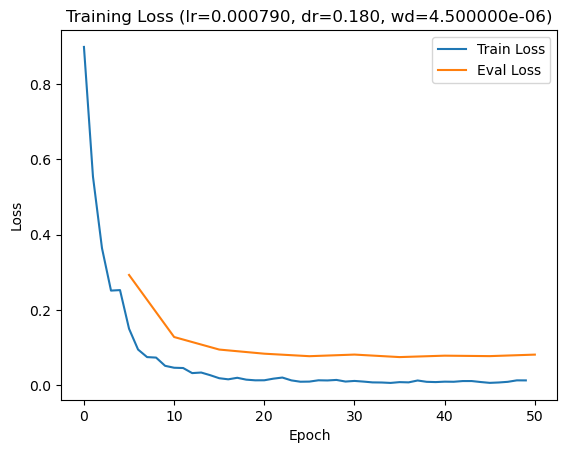


Best Model Results:
Best lr: 0.000790, Best dr: 0.180, Best wd: 4.500000e-06
MSE: 0.0068, MAE: 0.0379, R2: 0.9178
🏃 View run LSTM_Attempt_1 at: http://127.0.0.1:5000/#/experiments/705466357799796558/runs/589df84fee8a42e7a2414077582f5335
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/705466357799796558

Training with lr=0.0008, dr=0.18, wd=4.5e-06


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5, Train Loss: 0.2512, Eval Loss: 0.2574
Epoch 10, Train Loss: 0.0657, Eval Loss: 0.1625
Epoch 15, Train Loss: 0.0233, Eval Loss: 0.0960
Epoch 20, Train Loss: 0.0141, Eval Loss: 0.0924
Epoch 25, Train Loss: 0.0124, Eval Loss: 0.0870
Epoch 30, Train Loss: 0.0073, Eval Loss: 0.0766
Epoch 35, Train Loss: 0.0070, Eval Loss: 0.0723
Epoch 40, Train Loss: 0.0068, Eval Loss: 0.0745
Epoch 45, Train Loss: 0.0147, Eval Loss: 0.0744
Epoch 50, Train Loss: 0.0054, Eval Loss: 0.0687
lr: 0.000800, dr: 0.180, wd: 4.500000e-06, MSE: 0.0061, MAE: 0.0277, R2: 0.9267


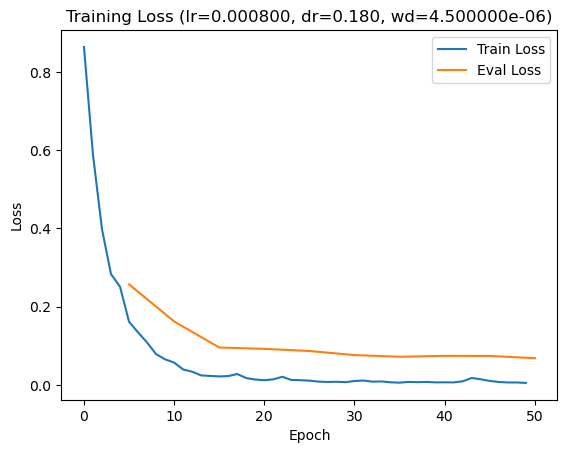


Best Model Results:
Best lr: 0.000800, Best dr: 0.180, Best wd: 4.500000e-06
MSE: 0.0061, MAE: 0.0277, R2: 0.9267
🏃 View run LSTM_Attempt_2 at: http://127.0.0.1:5000/#/experiments/705466357799796558/runs/f1bc96ef466a4a5d978dce73733e1db6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/705466357799796558

Training with lr=0.00081, dr=0.18, wd=4.5e-06


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5, Train Loss: 0.1799, Eval Loss: 0.2374
Epoch 10, Train Loss: 0.0524, Eval Loss: 0.1310
Epoch 15, Train Loss: 0.0282, Eval Loss: 0.0943
Epoch 20, Train Loss: 0.0275, Eval Loss: 0.1085
Epoch 25, Train Loss: 0.0077, Eval Loss: 0.0742
Epoch 30, Train Loss: 0.0099, Eval Loss: 0.0876
Epoch 35, Train Loss: 0.0090, Eval Loss: 0.0738
Epoch 40, Train Loss: 0.0100, Eval Loss: 0.0785
Epoch 45, Train Loss: 0.0083, Eval Loss: 0.0731
Epoch 50, Train Loss: 0.0074, Eval Loss: 0.0696
lr: 0.000810, dr: 0.180, wd: 4.500000e-06, MSE: 0.0062, MAE: 0.0301, R2: 0.9258


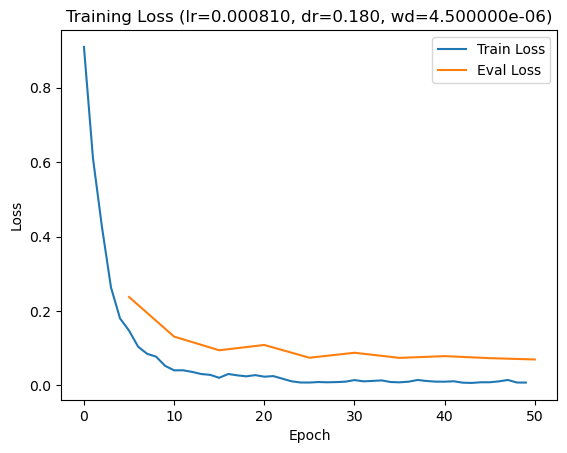


Best Model Results:
Best lr: 0.000810, Best dr: 0.180, Best wd: 4.500000e-06
MSE: 0.0062, MAE: 0.0301, R2: 0.9258
🏃 View run LSTM_Attempt_3 at: http://127.0.0.1:5000/#/experiments/705466357799796558/runs/0bbcb164b285414b9a724496e9895788
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/705466357799796558
LSTM: MSE=0.006176277529448271, MAE=0.030095746740698814, R-squared=0.9257800578469734


In [38]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("sentiment_model_lstm")

learning_rates_choice = [0.00079,0.00080,0.00081]
results = []
embeddings = get_wangchanberta_embeddings(df["complain_detail"].tolist())
for i, lr in enumerate(learning_rates_choice, start=1):
    with mlflow.start_run(run_name=f"LSTM_Attempt_{i}"):
        mse_lstm, mae_lstm, r2_lstm, model_lstm, scaler_lstm, best_params = train_and_evaluate(
            df.copy(),
            epochs=50,
            hidden_size=256,
            num_layers=3,
            learning_rates=[lr],
            dropout_rates=[0.18],
            weight_decays=[4.5e-06],
        )

        mlflow.log_metric("MSE", mse_lstm)
        mlflow.log_metric("MAE", mae_lstm)
        mlflow.log_metric("R-squared", r2_lstm)

        params_to_log = {
            "epochs": 50,
            "hidden_size": 256,
            "num_layers": 3,
            "learning_rate": lr,
            "dropout_rate": 0.18,
            "weight_decay": 4.5e-06,
        }
        mlflow.log_params(params_to_log)

        results.append({
            "learning_rate": lr,
            "model": model_lstm,
            "scaler": scaler_lstm,
            "r2": r2_lstm,
            "best_params": best_params
        })

best_run = max(results, key=lambda x: x["r2"])
best_model = best_run["model"]
best_scaler = best_run["scaler"]
best_params = best_run["best_params"]
print(f"LSTM: MSE={mse_lstm}, MAE={mae_lstm}, R-squared={r2_lstm}")

In [39]:
import joblib

joblib.dump(best_scaler, "scaler.pkl")

['scaler.pkl']

In [18]:
# 7. ฟังก์ชันสำหรับทำนาย Sentiment Score จากข้อความ
def predict_sentiment(text, model, scaler, model_type='LSTM'):
    embedding = get_wangchanberta_embeddings([text])  # Assuming this returns a NumPy array

    # Ensure embedding is a NumPy array
    if not isinstance(embedding, np.ndarray):
        raise TypeError("Embedding must be a NumPy array")

    embedding_tensor = torch.tensor(embedding, dtype=torch.float)

    with torch.no_grad():
        # Corrected line: Call the model directly
        output, _ = model(embedding_tensor)

        # Assuming your model outputs a single value or a 1D tensor
        # You might need to adjust this depending on your model's output shape
        score = scaler.inverse_transform(output.numpy())

    return score

In [19]:
# Example prediction
text_to_predict = "สฟ.ภูเก็ต 2 ขอรายละเอียดการทำงานของ Breaker PK2-7082 เมื่อวันที่ 24 ก.พ. 2557 เวลา 13.03 น. วงจร PK2-7082 มีการทำงาน Trip Lock out ทำเกิดกระแสไฟฟ้าขัดข้องในพื้นที่เมืองภูเก็ตบางส่วน,หาดกะตะ และหาดกะรน โหลดหาย 49.8 MW ศูนย์ควบคุมการจ่ายไฟ จ.ภูเก็ต ขอทราบรายละเอียดการทำงานของอุปกรณ์ป้องกันดังกล่าว เพื่อทำการตรวจสอบหาสาเหตุและวางแนวทางการแก้ไขต่อไป"
predicted_scores = predict_sentiment(text_to_predict, model_lstm, scaler_lstm, model_type='LSTM') # Use the best model
predicted_scores

array([[0.00122476, 0.22943632, 0.76946115]], dtype=float32)

In [20]:
# Example prediction
text_to_predict = "สฟ.ภูเก็ต 2 ขอรายละเอียดการทำงานของ Breaker PK2-7082 เมื่อวันที่ 24 ก.พ. 2557 เวลา 13.03 น. วงจร PK2-7082 มีการทำงาน Trip Lock out ทำเกิดกระแสไฟฟ้าขัดข้องในพื้นที่เมืองภูเก็ตบางส่วน,หาดกะตะ และหาดกะรน โหลดหาย 49.8 MW ศูนย์ควบคุมการจ่ายไฟ จ.ภูเก็ต ขอทราบรายละเอียดการทำงานของอุปกรณ์ป้องกันดังกล่าว เพื่อทำการตรวจสอบหาสาเหตุและวางแนวทางการแก้ไขต่อไป"
predicted_scores = predict_sentiment(text_to_predict, best_model, best_scaler, model_type='LSTM') # Use the best model
predicted_scores

array([[0.00122476, 0.22943632, 0.76946115]], dtype=float32)

In [21]:
complaints = [
    "ต้องการให้มีการตรวจสอบคุณภาพของอุปกรณ์ที่ติดตั้งให้ถี่ถ้วนกว่านี้ เนื่องจากพบปัญหาอุปกรณ์ชำรุดหลังจากติดตั้งได้ไม่นาน",
    "อยากให้ปรับปรุงระบบแจ้งเตือนเมื่อเกิดเหตุขัดข้องให้รวดเร็วและแม่นยำกว่านี้ เพื่อที่จะได้เตรียมตัวรับมือได้ทัน",
    "ขอให้ทาง กฟผ. ช่วยเร่งแก้ไขปัญหาไฟตก ไฟดับ ที่เกิดขึ้นบ่อยครั้งในพื้นที่นี้ด้วยครับ สร้างความเดือดร้อนในการใช้ชีวิตประจำวันมาก",
    "อยากให้มีช่องทางในการติดต่อกับเจ้าหน้าที่ที่หลากหลายกว่านี้ เช่น มี Chat Bot หรือ Line Official Account เพื่อความสะดวกในการสอบถามข้อมูล",
    "ขอให้มีการอบรมให้ความรู้เกี่ยวกับการใช้ไฟฟ้าอย่างปลอดภัยแก่ประชาชนทั่วไป เพื่อลดอุบัติเหตุที่อาจเกิดขึ้น",
    "อยากให้มีการประชาสัมพันธ์ข้อมูลข่าวสารเกี่ยวกับการดำเนินงานของ กฟผ. ให้ประชาชนได้รับทราบอย่างต่อเนื่องและทั่วถึง",
    "ขอให้มีการปรับปรุงภูมิทัศน์บริเวณสถานีไฟฟ้าให้มีความสวยงามและเป็นระเบียบเรียบร้อย เพื่อสร้างภาพลักษณ์ที่ดี",
    "อยากให้มีการส่งเสริมการใช้พลังงานสะอาดและพลังงานทดแทนให้มากขึ้น เพื่อลดผลกระทบต่อสิ่งแวดล้อม",
    "ขอให้มีการตรวจสอบและบำรุงรักษาสายส่งและอุปกรณ์ไฟฟ้าอย่างสม่ำเสมอ เพื่อป้องกันปัญหาไฟดับที่อาจเกิดขึ้น",
    "อยากให้มีการรับฟังความคิดเห็นของประชาชนอย่างสม่ำเสมอ เพื่อนำมาปรับปรุงการดำเนินงานให้ดียิ่งขึ้น",
    "ขอให้มีการพัฒนาระบบการชำระค่าไฟฟ้าให้มีความสะดวกและหลากหลายช่องทางมากขึ้น",
    "อยากให้มีการให้ความช่วยเหลือประชาชนที่ได้รับผลกระทบจากเหตุภัยพิบัติทางธรรมชาติอย่างทันท่วงที",
    "ขอให้มีการส่งเสริมการประหยัดพลังงานในภาคครัวเรือนและภาคอุตสาหกรรม",
    "อยากให้มีการควบคุมราคาค่าไฟฟ้าให้มีความเหมาะสมและเป็นธรรมกับผู้บริโภค",
    "ขอให้มีการปรับปรุงการให้บริการลูกค้าให้มีความรวดเร็วและมีประสิทธิภาพมากยิ่งขึ้น",
    "อยากให้มีการสร้างความเข้าใจและความสัมพันธ์ที่ดีกับชุมชนโดยรอบสถานีไฟฟ้า",
    "ขอให้มีการสนับสนุนการวิจัยและพัฒนาเทคโนโลยีด้านพลังงานไฟฟ้าอย่างต่อเนื่อง",
    "อยากให้มีการเปิดเผยข้อมูลการดำเนินงานของ กฟผ. ให้ประชาชนสามารถเข้าถึงและตรวจสอบได้",
    "ขอให้มีการส่งเสริมความโปร่งใสในการดำเนินงานของ กฟผ.",
    "อยากให้มีการพัฒนาบุคลากรของ กฟผ. ให้มีความรู้ความสามารถและมีคุณธรรมจริยธรรม"
]
complaints2 = [
    "ขอให้มีการปรับปรุงระบบการจ่ายไฟฟ้าให้มีความเสถียรมากขึ้น เนื่องจากพบปัญหาไฟตกบ่อยในช่วงฤดูฝน",
    "อยากให้มีการเพิ่มช่องทางการแจ้งเหตุไฟฟ้าขัดข้องให้หลากหลายมากขึ้น เช่น ผ่านแอปพลิเคชันบนมือถือ",
    "ขอให้มีการปรับปรุงการให้บริการข้อมูลข่าวสารผ่านทางเว็บไซต์ให้มีความทันสมัยและใช้งานง่ายมากขึ้น",
    "อยากให้มีการส่งเสริมการมีส่วนร่วมของประชาชนในการตรวจสอบการดำเนินงานของ กฟผ.",
    "ขอให้มีการปรับปรุงระบบการจัดการเรื่องร้องเรียนให้มีความรวดเร็วและมีประสิทธิภาพมากขึ้น",
    "อยากให้มีการส่งเสริมการใช้เทคโนโลยีใหม่ๆ ในการผลิตและส่งจ่ายไฟฟ้า",
    "ขอให้มีการปรับปรุงการสื่อสารกับประชาชนให้มีความชัดเจนและเข้าใจง่ายมากขึ้น",
    "อยากให้มีการส่งเสริมการพัฒนาบุคลากรให้มีความเชี่ยวชาญในด้านต่างๆ ที่เกี่ยวข้องกับการไฟฟ้า",
    "ขอให้มีการปรับปรุงการทำงานให้มีความปลอดภัยมากขึ้น เพื่อลดอุบัติเหตุที่อาจเกิดขึ้น",
    "อยากให้มีการส่งเสริมการอนุรักษ์พลังงานในทุกภาคส่วน",
    "ขอให้มีการปรับปรุงการให้บริการลูกค้าให้มีความเป็นมืออาชีพมากขึ้น",
    "อยากให้มีการส่งเสริมการท่องเที่ยวเชิงอนุรักษ์ในพื้นที่ที่มีโรงไฟฟ้าตั้งอยู่",
    "ขอให้มีการปรับปรุงการบริหารจัดการให้มีประสิทธิภาพมากขึ้น",
    "อยากให้มีการส่งเสริมการลงทุนในโครงสร้างพื้นฐานด้านพลังงานไฟฟ้า",
    "ขอให้มีการปรับปรุงการดำเนินงานให้มีความรับผิดชอบต่อสังคมและสิ่งแวดล้อมมากขึ้น",
    "อยากให้มีการส่งเสริมการสร้างงานและสร้างรายได้ให้กับประชาชนในพื้นที่ที่มีโรงไฟฟ้าตั้งอยู่",
    "ขอให้มีการปรับปรุงการวางแผนการผลิตไฟฟ้าให้สอดคล้องกับความต้องการของประชาชน",
    "อยากให้มีการส่งเสริมการพัฒนาเทคโนโลยีพลังงานทดแทนให้มีประสิทธิภาพมากขึ้น",
    "ขอให้มีการปรับปรุงการกระจายไฟฟ้าให้ทั่วถึงและเป็นธรรม",
    "อยากให้มีการส่งเสริมการพัฒนาองค์กรให้มีความยั่งยืนในระยะยาว"
]

In [22]:
# Predict sentiment for each complaint
def run_lstm(complaints):
    predicted_sentiments = []
    for complaint in complaints:
        scores = predict_sentiment(complaint, model_lstm, scaler_lstm, model_type='LSTM')
        predicted_sentiments.append(scores)
    
    # Print the results
    for i, complaint in enumerate(complaints):
        print(f"Complaint: {complaint}")
        print(f"Predicted Scores: {predicted_sentiments[i]}")
        print("-" * 20)

In [23]:
# Predict sentiment for each complaint
def run_bestmodels(complaints):
    predicted_sentiments = []
    for complaint in complaints:
        scores = predict_sentiment(complaint, best_model, best_scaler, model_type='LSTM')
        predicted_sentiments.append(scores)
    
    # Print the results
    for i, complaint in enumerate(complaints):
        print(f"Complaint: {complaint}")
        print(f"Predicted Scores: {predicted_sentiments[i]}")
        print("-" * 20)

In [24]:
run_lstm(complaints)

Complaint: ต้องการให้มีการตรวจสอบคุณภาพของอุปกรณ์ที่ติดตั้งให้ถี่ถ้วนกว่านี้ เนื่องจากพบปัญหาอุปกรณ์ชำรุดหลังจากติดตั้งได้ไม่นาน
Predicted Scores: [[0.02969196 0.25866857 0.71168834]]
--------------------
Complaint: อยากให้ปรับปรุงระบบแจ้งเตือนเมื่อเกิดเหตุขัดข้องให้รวดเร็วและแม่นยำกว่านี้ เพื่อที่จะได้เตรียมตัวรับมือได้ทัน
Predicted Scores: [[0.02963599 0.3445735  0.62601835]]
--------------------
Complaint: ขอให้ทาง กฟผ. ช่วยเร่งแก้ไขปัญหาไฟตก ไฟดับ ที่เกิดขึ้นบ่อยครั้งในพื้นที่นี้ด้วยครับ สร้างความเดือดร้อนในการใช้ชีวิตประจำวันมาก
Predicted Scores: [[0.09603747 0.28883043 0.6161266 ]]
--------------------
Complaint: อยากให้มีช่องทางในการติดต่อกับเจ้าหน้าที่ที่หลากหลายกว่านี้ เช่น มี Chat Bot หรือ Line Official Account เพื่อความสะดวกในการสอบถามข้อมูล
Predicted Scores: [[0.00549183 0.1869924  0.8076663 ]]
--------------------
Complaint: ขอให้มีการอบรมให้ความรู้เกี่ยวกับการใช้ไฟฟ้าอย่างปลอดภัยแก่ประชาชนทั่วไป เพื่อลดอุบัติเหตุที่อาจเกิดขึ้น
Predicted Scores: [[0.01458553 0.61135453 0.3

In [25]:
run_bestmodels(complaints)

Complaint: ต้องการให้มีการตรวจสอบคุณภาพของอุปกรณ์ที่ติดตั้งให้ถี่ถ้วนกว่านี้ เนื่องจากพบปัญหาอุปกรณ์ชำรุดหลังจากติดตั้งได้ไม่นาน
Predicted Scores: [[0.02969196 0.25866857 0.71168834]]
--------------------
Complaint: อยากให้ปรับปรุงระบบแจ้งเตือนเมื่อเกิดเหตุขัดข้องให้รวดเร็วและแม่นยำกว่านี้ เพื่อที่จะได้เตรียมตัวรับมือได้ทัน
Predicted Scores: [[0.02963599 0.3445735  0.62601835]]
--------------------
Complaint: ขอให้ทาง กฟผ. ช่วยเร่งแก้ไขปัญหาไฟตก ไฟดับ ที่เกิดขึ้นบ่อยครั้งในพื้นที่นี้ด้วยครับ สร้างความเดือดร้อนในการใช้ชีวิตประจำวันมาก
Predicted Scores: [[0.09603747 0.28883043 0.6161266 ]]
--------------------
Complaint: อยากให้มีช่องทางในการติดต่อกับเจ้าหน้าที่ที่หลากหลายกว่านี้ เช่น มี Chat Bot หรือ Line Official Account เพื่อความสะดวกในการสอบถามข้อมูล
Predicted Scores: [[0.00549183 0.1869924  0.8076663 ]]
--------------------
Complaint: ขอให้มีการอบรมให้ความรู้เกี่ยวกับการใช้ไฟฟ้าอย่างปลอดภัยแก่ประชาชนทั่วไป เพื่อลดอุบัติเหตุที่อาจเกิดขึ้น
Predicted Scores: [[0.01458553 0.61135453 0.3

In [26]:
run_lstm(complaints2)

Complaint: ขอให้มีการปรับปรุงระบบการจ่ายไฟฟ้าให้มีความเสถียรมากขึ้น เนื่องจากพบปัญหาไฟตกบ่อยในช่วงฤดูฝน
Predicted Scores: [[0.03492015 0.44785884 0.5176573 ]]
--------------------
Complaint: อยากให้มีการเพิ่มช่องทางการแจ้งเหตุไฟฟ้าขัดข้องให้หลากหลายมากขึ้น เช่น ผ่านแอปพลิเคชันบนมือถือ
Predicted Scores: [[0.12430892 0.6135175  0.26257348]]
--------------------
Complaint: ขอให้มีการปรับปรุงการให้บริการข้อมูลข่าวสารผ่านทางเว็บไซต์ให้มีความทันสมัยและใช้งานง่ายมากขึ้น
Predicted Scores: [[0.17981927 0.53540325 0.28455237]]
--------------------
Complaint: อยากให้มีการส่งเสริมการมีส่วนร่วมของประชาชนในการตรวจสอบการดำเนินงานของ กฟผ.
Predicted Scores: [[0.5230721  0.2855022  0.19152719]]
--------------------
Complaint: ขอให้มีการปรับปรุงระบบการจัดการเรื่องร้องเรียนให้มีความรวดเร็วและมีประสิทธิภาพมากขึ้น
Predicted Scores: [[0.6447622  0.24780215 0.10719094]]
--------------------
Complaint: อยากให้มีการส่งเสริมการใช้เทคโนโลยีใหม่ๆ ในการผลิตและส่งจ่ายไฟฟ้า
Predicted Scores: [[0.7498238  0.08390384 0

In [27]:
run_bestmodels(complaints2)

Complaint: ขอให้มีการปรับปรุงระบบการจ่ายไฟฟ้าให้มีความเสถียรมากขึ้น เนื่องจากพบปัญหาไฟตกบ่อยในช่วงฤดูฝน
Predicted Scores: [[0.03492015 0.44785884 0.5176573 ]]
--------------------
Complaint: อยากให้มีการเพิ่มช่องทางการแจ้งเหตุไฟฟ้าขัดข้องให้หลากหลายมากขึ้น เช่น ผ่านแอปพลิเคชันบนมือถือ
Predicted Scores: [[0.12430892 0.6135175  0.26257348]]
--------------------
Complaint: ขอให้มีการปรับปรุงการให้บริการข้อมูลข่าวสารผ่านทางเว็บไซต์ให้มีความทันสมัยและใช้งานง่ายมากขึ้น
Predicted Scores: [[0.17981927 0.53540325 0.28455237]]
--------------------
Complaint: อยากให้มีการส่งเสริมการมีส่วนร่วมของประชาชนในการตรวจสอบการดำเนินงานของ กฟผ.
Predicted Scores: [[0.5230721  0.2855022  0.19152719]]
--------------------
Complaint: ขอให้มีการปรับปรุงระบบการจัดการเรื่องร้องเรียนให้มีความรวดเร็วและมีประสิทธิภาพมากขึ้น
Predicted Scores: [[0.6447622  0.24780215 0.10719094]]
--------------------
Complaint: อยากให้มีการส่งเสริมการใช้เทคโนโลยีใหม่ๆ ในการผลิตและส่งจ่ายไฟฟ้า
Predicted Scores: [[0.7498238  0.08390384 0

In [28]:
all_reviews = [
  # รีวิว/ความคิดเห็นเกี่ยวกับธุรกิจการผลิตไฟฟ้า
    "โรงไฟฟ้าพลังงานหมุนเวียนของ กฟผ. ช่วยลดผลกระทบต่อสิ่งแวดล้อมได้ดีมากครับ ขอชื่นชม",
    "อยากให้เพิ่มจำนวนโรงไฟฟ้าพลังงานแสงอาทิตย์ให้มากขึ้น เพื่อตอบสนองความต้องการใช้พลังงานสะอาด",
    "โรงไฟฟ้าพลังความร้อนร่วม มีประสิทธิภาพในการผลิตไฟฟ้าสูงมาก แต่ก็อยากให้ควบคุมการปล่อยมลพิษให้เข้มงวดกว่านี้",
    "การรับซื้อไฟฟ้าจากผู้ผลิตเอกชนรายเล็ก ช่วยส่งเสริมผู้ประกอบการในท้องถิ่นได้ดีครับ",
    "การรับซื้อไฟฟ้าจากประเทศเพื่อนบ้าน ช่วยให้มีแหล่งพลังงานที่หลากหลายมากขึ้น",
    "ปัญหาไฟตกไฟดับยังคงเกิดขึ้นบ้างในบางพื้นที่ อยากให้ กฟผ. ปรับปรุงระบบส่งไฟฟ้าให้มีเสถียรภาพมากขึ้น",
    "อยากให้มีข้อมูลเกี่ยวกับแผนการก่อสร้างโรงไฟฟ้าแห่งใหม่ๆ ให้ประชาชนได้รับทราบมากขึ้น",
    "การมีโรงไฟฟ้าหลากหลายประเภท ช่วยให้มีแหล่งพลังงานสำรองที่มั่นคง",
    "อยากให้ กฟผ. ลงทุนในเทคโนโลยีการผลิตไฟฟ้าที่ทันสมัยมากขึ้น เพื่อลดต้นทุนและเพิ่มประสิทธิภาพ",
    "การบำรุงรักษาโรงไฟฟ้าเป็นสิ่งสำคัญ ควรมีแผนการตรวจสอบและบำรุงรักษาที่เข้มงวด",
    "โรงไฟฟ้าพลังน้ำ เป็นแหล่งพลังงานสะอาดที่สำคัญ อยากให้มีการบริหารจัดการน้ำให้มีประสิทธิภาพ",
    "การผลิตไฟฟ้าจากพลังงานลม เป็นทางเลือกที่ดีสำหรับอนาคต",
    "โรงไฟฟ้าดีเซล ควรใช้ในกรณีฉุกเฉินเท่านั้น เพื่อลดผลกระทบต่อสิ่งแวดล้อม",
    "อยากให้มีข้อมูลเกี่ยวกับการปล่อยมลพิษของโรงไฟฟ้าแต่ละแห่งให้ประชาชนเข้าถึงได้ง่าย",
    "การมีส่วนร่วมของชุมชนในการวางแผนและตัดสินใจเกี่ยวกับโรงไฟฟ้า เป็นสิ่งสำคัญ",
    "กฟผ. ควรให้ความสำคัญกับการลดผลกระทบต่อสิ่งแวดล้อมและชุมชน",
    "อยากให้มีการลงทุนในเทคโนโลยีการดักจับและกักเก็บคาร์บอนไดออกไซด์",
    "การมีแหล่งพลังงานที่หลากหลาย ช่วยลดความเสี่ยงจากการพึ่งพาแหล่งพลังงานใดแหล่งพลังงานหนึ่ง",
    "กฟผ. ควรเป็นผู้นำในการเปลี่ยนผ่านสู่พลังงานสะอาด",
    "อยากให้มีการส่งเสริมการใช้พลังงานแสงอาทิตย์บนหลังคาบ้านและอาคาร",
    "การตรวจสอบตัว VT CT ที่อยู่ในระบบ ว่าถึงช่วงกำหนดเปลี่ยนแล้วหรือไม่ หากถึงเวลาเปลี่ยนควรเปลี่ยน บางครั้งพบว่า VT ชำรุด ไม่สามารถออกหน่วยได้ใช้วิธีการเฉลี่ย",
    "อยากทราบข้อมูลเกี่ยวกับขั้นตอนการขออนุญาตติดตั้งโซลาร์ฟาร์มขนาดใหญ่",
    "มีปัญหาไฟตกบ่อยในช่วงฤดูฝน รบกวนตรวจสอบและแก้ไขด้วยครับ",
    "การยืนยันการซื้อขายไฟฟ้า ควรทำให้รวดเร็วขึ้น โดยเฉพาะในช่วงวันหยุด",
    "อยากทราบข้อมูลเกี่ยวกับแผนการพัฒนาโรงไฟฟ้าพลังงานนิวเคลียร์ของ กฟผ.",
    "การมีส่วนร่วมของชุมชนในการตัดสินใจเรื่องโรงไฟฟ้า ควรเปิดโอกาสให้มากขึ้น",
    "ร้องเรียนเรื่องเสียงดังจากโรงไฟฟ้าใกล้บ้าน รบกวนตรวจสอบด้วยครับ",
    "อยากให้มีการจัดกิจกรรมให้ความรู้เกี่ยวกับพลังงานสะอาดแก่ประชาชนมากขึ้น",
    "อยากทราบข้อมูลเกี่ยวกับโครงการสนับสนุนการติดตั้งโซลาร์รูฟท็อปสำหรับครัวเรือน",
    "ชื่นชมการทำงานของเจ้าหน้าที่ กฟผ. ที่แก้ไขปัญหาไฟดับได้อย่างรวดเร็ว",
    
    # รีวิว/ความคิดเห็นเกี่ยวกับธุรกิจการส่งไฟฟ้า
    "ระบบส่งไฟฟ้าของ กฟผ. ครอบคลุมทั่วประเทศ ทำให้มีไฟฟ้าใช้ได้อย่างทั่วถึง",
    "ปัญหาไฟตกไฟดับยังคงเกิดขึ้นบ้างในบางพื้นที่ อยากให้ปรับปรุงระบบส่งไฟฟ้าให้มีเสถียรภาพมากขึ้น",
    "อยากให้มีข้อมูลเกี่ยวกับการบำรุงรักษาระบบส่งไฟฟ้าให้ประชาชนได้รับทราบมากขึ้น",
    "การมีระบบส่งไฟฟ้าแรงดันสูง ช่วยให้ส่งไฟฟ้าได้ในปริมาณมากและระยะทางไกล",
    "อยากให้มีการลงทุนในเทคโนโลยี Smart Grid เพื่อเพิ่มประสิทธิภาพและความมั่นคงของระบบส่งไฟฟ้า",
    "การบำรุงรักษาสายส่งไฟฟ้าแรงสูง เป็นงานที่อันตรายและมีความเสี่ยงสูง ควรมีมาตรการความปลอดภัยที่เข้มงวด",
    "อยากให้มีการลดผลกระทบของสายส่งไฟฟ้าต่อสิ่งแวดล้อมและสุขภาพของประชาชน",
    "การมีส่วนร่วมของชุมชนในการวางแผนและตัดสินใจเกี่ยวกับระบบส่งไฟฟ้า เป็นสิ่งสำคัญ",
    "กฟผ. ควรให้ความสำคัญกับการลดการสูญเสียพลังงานในระบบส่งไฟฟ้า",
    "อยากให้มีการใช้สายส่งไฟฟ้าใต้ดินในพื้นที่ชุมชน เพื่อลดผลกระทบต่อทัศนียภาพ",
    "การมีระบบควบคุมและป้องกันที่ทันสมัย ช่วยลดความเสี่ยงจากไฟฟ้าดับ",
    "อยากให้มีการตรวจสอบและบำรุงรักษาสถานีไฟฟ้าแรงสูงอย่างสม่ำเสมอ",
    "การมีระบบสื่อสารและโทรคมนาคมที่ทันสมัย ช่วยให้ควบคุมและจัดการระบบส่งไฟฟ้าได้อย่างมีประสิทธิภาพ",
    "อยากให้มีการฝึกอบรมและพัฒนาบุคลากรให้มีความเชี่ยวชาญด้านระบบส่งไฟฟ้า",
    "การมีระบบสำรองฉุกเฉิน ช่วยให้มีไฟฟ้าใช้ได้อย่างต่อเนื่องในกรณีเกิดเหตุฉุกเฉิน",
    "กฟผ. ควรให้ความสำคัญกับการลดผลกระทบต่อสิ่งแวดล้อมและชุมชน",
    "อยากให้มีการลงทุนในเทคโนโลยีการป้องกันฟ้าผ่า เพื่อลดปัญหาไฟตกไฟดับ",
    "การมีแหล่งพลังงานสำรองที่มั่นคง ช่วยให้มีไฟฟ้าใช้ได้อย่างต่อเนื่องในกรณีเกิดเหตุฉุกเฉิน",
    "กฟผ. ควรเป็นผู้นำในการพัฒนาระบบส่งไฟฟ้าที่ทันสมัยและมีประสิทธิภาพ",
    "อยากให้มีการส่งเสริมการใช้เทคโนโลยี Smart Grid เพื่อเพิ่มประสิทธิภาพและความมั่นคงของระบบส่งไฟฟ้า",
    "ปัญหา Trip Reclose เนื่องจากฟ้าผ่าบ่อย ในปีที่ผ่านมา เหมือนจะมีปัญหา Trip Reclose เนื่องจากฟ้าผ่าบ่อยกว่าทุกปี ส่งผลให้เกิด Voltage Dip เป็นพื้นที่บริเวณกว้าง",
    "อยากทราบขั้นตอนการขอเชื่อมต่อระบบไฟฟ้าของโรงงานอุตสาหกรรมขนาดใหญ่",
    "สายส่งไฟฟ้าแรงสูงใกล้บ้านมีเสียงดัง รบกวนตรวจสอบและแก้ไขด้วยครับ",
    "อยากทราบข้อมูลเกี่ยวกับแผนการพัฒนาระบบสายส่งไฟฟ้าใต้ดินในพื้นที่กรุงเทพฯ",
    "การมีส่วนร่วมของชุมชนในการวางแผนระบบสายส่งไฟฟ้า ควรเปิดโอกาสให้มากขึ้น",
    "ร้องเรียนเรื่องสายส่งไฟฟ้าแรงสูงกีดขวางการก่อสร้างบ้าน รบกวนตรวจสอบด้วยครับ",
    "อยากให้มีการจัดกิจกรรมให้ความรู้เกี่ยวกับความปลอดภัยในการอยู่ใกล้สายส่งไฟฟ้าแรงสูง",
    "อยากทราบข้อมูลเกี่ยวกับโครงการปรับปรุงระบบส่งไฟฟ้าในพื้นที่ชนบท",
    "ชื่นชมการทำงานของเจ้าหน้าที่ กฟผ. ที่แก้ไขปัญหาไฟดับได้อย่างรวดเร็ว",
    "อยากให้ตรวจสอบเสาไฟฟ้าแรงสูงต้นที่อยู่หน้าบ้านของผมว่ามีรอยร้าวหรือไม่",

    # รีวิว/ความคิดเห็นเกี่ยวกับธุรกิจอื่นๆ (โรงไฟฟ้าและระบบส่ง)
    "งานวิศวกรรมและก่อสร้างโรงไฟฟ้าของ กฟผ. มีคุณภาพและได้มาตรฐาน",
    "อยากให้มีการเปิดเผยข้อมูลเกี่ยวกับงานวิศวกรรมและก่อสร้างโรงไฟฟ้าให้มากขึ้น",
    "งานเดินเครื่องและบำรุงรักษาโรงไฟฟ้าของ กฟผ. มีประสิทธิภาพและเชื่อถือได้",
    "อยากให้มีการฝึกอบรมและพัฒนาบุคลากรให้มีความเชี่ยวชาญด้านงานเดินเครื่องและบำรุงรักษาโรงไฟฟ้า",
    "งานบำรุงรักษาระบบส่งไฟฟ้าของ กฟผ. มีความสำคัญต่อความมั่นคงของระบบไฟฟ้า",
    "อยากให้มีการตรวจสอบและบำรุงรักษาสายส่งไฟฟ้าแรงสูงอย่างสม่ำเสมอ",
    "ธุรกิจโทรคมนาคมของ กฟผ. ช่วยให้มีการสื่อสารที่รวดเร็วและมีประสิทธิภาพ",
    "อยากให้มีการขยายโครงข่ายโทรคมนาคมให้ครอบคลุมพื้นที่มากขึ้น",
    "การให้บริการโครงข่ายโทรคมนาคมผ่านเส้นใยแก้วนำแสงของ กฟผ. มีความน่าสนใจ",
    "อยากให้มีการโปรโมทบริการโทรคมนาคมของ กฟผ. ให้มากขึ้น",
    "กฟผ. ควรให้ความสำคัญกับความปลอดภัยในการทำงานของบุคลากร",
    "อยากให้มีการลดผลกระทบต่อสิ่งแวดล้อมจากงานก่อสร้างและบำรุงรักษา",
    "การมีส่วนร่วมของชุมชนในการวางแผนและตัดสินใจเกี่ยวกับงานก่อสร้างและบำรุงรักษา เป็นสิ่งสำคัญ",
]

In [29]:
run_lstm(all_reviews)

Complaint: โรงไฟฟ้าพลังงานหมุนเวียนของ กฟผ. ช่วยลดผลกระทบต่อสิ่งแวดล้อมได้ดีมากครับ ขอชื่นชม
Predicted Scores: [[0.09687652 0.60069466 0.30269668]]
--------------------
Complaint: อยากให้เพิ่มจำนวนโรงไฟฟ้าพลังงานแสงอาทิตย์ให้มากขึ้น เพื่อตอบสนองความต้องการใช้พลังงานสะอาด
Predicted Scores: [[0.23637532 0.21786727 0.5469388 ]]
--------------------
Complaint: โรงไฟฟ้าพลังความร้อนร่วม มีประสิทธิภาพในการผลิตไฟฟ้าสูงมาก แต่ก็อยากให้ควบคุมการปล่อยมลพิษให้เข้มงวดกว่านี้
Predicted Scores: [[0.0358725  0.79083866 0.17276156]]
--------------------
Complaint: การรับซื้อไฟฟ้าจากผู้ผลิตเอกชนรายเล็ก ช่วยส่งเสริมผู้ประกอบการในท้องถิ่นได้ดีครับ
Predicted Scores: [[0.02203993 0.573878   0.40332404]]
--------------------
Complaint: การรับซื้อไฟฟ้าจากประเทศเพื่อนบ้าน ช่วยให้มีแหล่งพลังงานที่หลากหลายมากขึ้น
Predicted Scores: [[-0.00080385  0.62399054  0.37443548]]
--------------------
Complaint: ปัญหาไฟตกไฟดับยังคงเกิดขึ้นบ้างในบางพื้นที่ อยากให้ กฟผ. ปรับปรุงระบบส่งไฟฟ้าให้มีเสถียรภาพมากขึ้น
Predicted Sco

In [30]:
run_bestmodels(all_reviews)

Complaint: โรงไฟฟ้าพลังงานหมุนเวียนของ กฟผ. ช่วยลดผลกระทบต่อสิ่งแวดล้อมได้ดีมากครับ ขอชื่นชม
Predicted Scores: [[0.09687652 0.60069466 0.30269668]]
--------------------
Complaint: อยากให้เพิ่มจำนวนโรงไฟฟ้าพลังงานแสงอาทิตย์ให้มากขึ้น เพื่อตอบสนองความต้องการใช้พลังงานสะอาด
Predicted Scores: [[0.23637532 0.21786727 0.5469388 ]]
--------------------
Complaint: โรงไฟฟ้าพลังความร้อนร่วม มีประสิทธิภาพในการผลิตไฟฟ้าสูงมาก แต่ก็อยากให้ควบคุมการปล่อยมลพิษให้เข้มงวดกว่านี้
Predicted Scores: [[0.0358725  0.79083866 0.17276156]]
--------------------
Complaint: การรับซื้อไฟฟ้าจากผู้ผลิตเอกชนรายเล็ก ช่วยส่งเสริมผู้ประกอบการในท้องถิ่นได้ดีครับ
Predicted Scores: [[0.02203993 0.573878   0.40332404]]
--------------------
Complaint: การรับซื้อไฟฟ้าจากประเทศเพื่อนบ้าน ช่วยให้มีแหล่งพลังงานที่หลากหลายมากขึ้น
Predicted Scores: [[-0.00080385  0.62399054  0.37443548]]
--------------------
Complaint: ปัญหาไฟตกไฟดับยังคงเกิดขึ้นบ้างในบางพื้นที่ อยากให้ กฟผ. ปรับปรุงระบบส่งไฟฟ้าให้มีเสถียรภาพมากขึ้น
Predicted Sco

In [31]:
# Save the best model
def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)
    print(f"Model saved to {file_path}")

In [32]:
# Load the model
def load_model(file_path, input_size, hidden_size, num_layers, dropout_rate):
    model = create_model(input_size, hidden_size, num_layers, dropout_rate)
    model.load_state_dict(torch.load(file_path))
    model.eval()
    print(f"Model loaded from {file_path}")
    return model

In [33]:
# Example usage
if __name__ == "__main__":
    # Save the best model
    model_file = "best_model_lstm.pth"
    save_model(best_model, model_file)

    # Load the model for inference
    input_size = embeddings.shape[1]  # Assuming embeddings are already defined
    hidden_size = 256
    num_layers = 3
    dropout_rate = best_params["dropout_rate"]
    loaded_model = load_model(model_file, input_size, hidden_size, num_layers, dropout_rate)

    # Predict sentiment for a new text
    text_to_predict = "อยากให้มีการปรับปรุงระบบแจ้งเตือนเมื่อเกิดเหตุขัดข้องให้รวดเร็วและแม่นยำกว่านี้"
    embedding = get_wangchanberta_embeddings([text_to_predict])
    embedding_tensor = torch.tensor(embedding, dtype=torch.float32)
    with torch.no_grad():
        output = loaded_model(embedding_tensor)
        if isinstance(output, tuple):
            output = output[0]
        predicted_scores = best_scaler.inverse_transform(output.cpu().numpy())
    
print(f"Predicted Scores: {predicted_scores}")

Model saved to best_model_lstm.pth
Model loaded from best_model_lstm.pth
Predicted Scores: [[0.10859674 0.3257171  0.56640714]]


NameError: name 'X_train' is not defined

In [ ]:
# embeddings = get_wangchanberta_embeddings(df["complain_detail"].tolist())
# scores = df[["positive", "neutral", "negative"]].values
# normalized_scores, scaler = normalize_scores(scores)

# print(f"embeddings type: {type(embeddings)}")
# print(f"normalized_scores type: {type(normalized_scores)}")

# mse_rnn, mae_rnn, r2_rnn, model_rnn, scaler_rnn, best_params_rnn = train_and_evaluate(
#     df.copy(),
#     epochs=50,  # You can adjust this
#     hidden_size=256,
#     num_layers=3,
# )
# print(f"LSTM: MSE={mse_rnn}, MAE={mae_rnn}, R-squared={r2_rnn}")